# 프로젝트 9-1: 모든 장르 간 편향성 측정해보기 

1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. target, attribute 단어 셋 만들기 - TFIDF, LDA
4. WEAT score 계산과 시각화하기

## 0. 필요 클래스 및 함수 정의

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import dot
from numpy.linalg import norm
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from konlpy.tag import Okt

In [2]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [3]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis = -1)
    mean_B = np.mean(c_b, axis = -1)
    return mean_A - mean_B

In [88]:
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis = 0))
    return (mean_X - mean_Y) / std_dev

## 1. 데이터 로드하기

In [7]:
okt = Okt()
tokenized = []
with open(os.getenv("HOME") + "/aiffel/weat/synopsis.txt", 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem = True, norm = True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

print(len(tokenized))

71156


## 2. Embedding 모델 만들기

In [9]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size = 100, window = 5, min_count = 3, sg = 0)

In [10]:
model.wv.most_similar(positive = ['영화'])

[('작품', 0.8883106112480164),
 ('다큐멘터리', 0.8397124409675598),
 ('영화로', 0.8040646910667419),
 ('드라마', 0.8034080266952515),
 ('시대극', 0.7763749957084656),
 ('주제', 0.772083580493927),
 ('코미디', 0.7704250812530518),
 ('형식', 0.7660905718803406),
 ('설정', 0.7657263875007629),
 ('실화', 0.7596107125282288)]

In [37]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv("HOME") + "/aiffel/weat/" + file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem = True, norm = True)
            res = []
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    res.append(word[0])
            result.append(res)
    
    return result

In [38]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [43]:
art

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌'],
 ['은수', '상우', '미련', '집착', '감정', '이기', '못', '서울', '강릉', '간다'],
 ['태희',
  '배두나',
  '분',
  '깍쟁이',
  '혜주',
  '이요원',
  '분',
  '그림',
  '지영',
  '옥',
  '지영',
  '분',
  '쌍둥이',
  '비류',
  '이은실',
  '분',
  '온조',
  '이은주',
  '분',
  '단짝',
  '친구',
  '늘',
  '그',
  '스무',
  '살이',
  '길이',
  '증권',
  '회사',
  '입사',
  '혜주',
  '커리어우먼',
  '야심',
  '미술',
  '재능',
  '지영은',
  '유학',
  '한편',
  '태희',
  '봉사활동',
  '알',
  '뇌성마비',
  '시인'],
 ['날',
  '지영',
  '길',
  '새끼',
  '고양이',
  '티티',
  '스무',
  '살',
  '그녀',
  '삶',


## 3. LDA 키워드 추출하기

### LDA를 통한 키워드 추출 (실험)

In [16]:
# LDA를 통한 키워드 추출
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [62]:
def lda_analysis(text, n_topics = 3, n_keywords = 15):
    # tf-idf 사용 안하는 대신 max_df 규제를 통해 최다 빈출 단어 top 5% 제거
    text = [' '.join(doc) for doc in text]
    vectorizer = CountVectorizer(max_df = 0.95, min_df = 2)
    X = vectorizer.fit_transform(text)
    
    lda = LatentDirichletAllocation(n_components = n_topics, random_state = 2024)
    lda.fit(X)
    
    words = vectorizer.get_feature_names_out()
    topic_keywords = {}
    for topic_idx, topic in enumerate(lda.components_):
        print(f"토픽 {topic_idx + 1}: ")
        keywords = [words[i] for i in topic.argsort()[:-n_keywords -1 : -1]]
        print(", ".join(keywords))
        topic_keywords[topic_idx + 1] = keywords
        
    return topic_keywords


In [64]:
target_art = lda_analysis(art)
#target_art

토픽 1: 
시작, 위해, 그녀, 아이, 세상, 사람, 엄마, 자신, 남자, 아빠, 모든, 아내, 사랑, 여자, 아버지
토픽 2: 
사랑, 그녀, 자신, 사람, 영화, 시작, 친구, 위해, 마음, 서로, 영화제, 남자, 이야기, 다시, 다른
토픽 3: 
사건, 시작, 자신, 위해, 그녀, 영화, 세계, 감독, 마을, 친구, 가족, 미국, 인간, 이야기, 비밀


In [66]:
# 2번이 예술 영화스러운 듯...?
target_art[2]

['사랑',
 '그녀',
 '자신',
 '사람',
 '영화',
 '시작',
 '친구',
 '위해',
 '마음',
 '서로',
 '영화제',
 '남자',
 '이야기',
 '다시',
 '다른']

In [65]:
# 여기도 2번이 상업영화 생각했을 때 떠오르는 단어가 많은 것 같다
target_gen = lda_analysis(gen)
#target_gen

토픽 1: 
영화제, 국제, 영화, 서울, 이야기, 단편, 작품, 사람, 대한, 감독, 애니메이션, 우리, 통해, 세계, 연출
토픽 2: 
위해, 자신, 시작, 사건, 마을, 사람, 경찰, 친구, 과연, 조직, 세계, 모든, 살인, 발견, 가족
토픽 3: 
그녀, 자신, 남자, 사랑, 친구, 시작, 사람, 여자, 남편, 위해, 엄마, 아버지, 마음, 아들, 아내


In [67]:
target_gen[2]

['위해',
 '자신',
 '시작',
 '사건',
 '마을',
 '사람',
 '경찰',
 '친구',
 '과연',
 '조직',
 '세계',
 '모든',
 '살인',
 '발견',
 '가족']

### 장르별 key words 확인하기...

In [ ]:
# 장르 파일 확인하기
dir_path = os.getenv("HOME")+"/aiffel/weat"
substract_names = ['synopsis_art.txt', 'synopsis_gen.txt', 'synopsis.txt']
genre_txt = []

for fname in os.listdir(dir_path):
    if fname.endswith('.txt'):
        if fname not in substract_names:
            genre_txt.append(fname)

genre_txt

In [78]:
genre_txt[0][9:-4]

'action'

In [79]:
genre_name = [txt[9:-4] for txt in genre_txt]
genre_name

['action',
 'family',
 'show',
 'thriller',
 'western',
 'etc',
 'adult',
 'mystery',
 'horror',
 'historical',
 'romance',
 'war',
 'SF',
 'animation',
 'documentary',
 'crime',
 'musical',
 'fantasy',
 'comedy',
 'drama',
 'adventure']

In [80]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_action.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.


In [82]:
attribute_dict = {}
for name, text in zip(genre_name, genre):
    print("------------------------------------------------")
    print("LDA Analysis for ", name, "is being processed...")
    attribute_dict[name] = lda_analysis(text)


------------------------------------------------
LDA Analysis for  action is being processed...
토픽 1: 
자신, 위해, 사건, 조직, 영화, 경찰, 사람, 형사, 살인, 요원, 친구, 그녀, 임무, 범죄, 동료
토픽 2: 
위해, 자신, 그녀, 조직, 시작, 복수, 사람, 사랑, 친구, 운명, 목숨, 세계, 남자, 납치, 한편
토픽 3: 
시작, 자신, 위해, 사건, 인간, 전쟁, 경찰, 사실, 지구, 목숨, 사람, 비밀, 공격, 모든, 가족
------------------------------------------------
LDA Analysis for  family is being processed...
토픽 1: 
영화제, 엄마, 아빠, 국제, 할머니, 학교, 가족, 자신, 서울, 사람, 아주르, 위해, 고양이, 시작, 영화
토픽 2: 
아버지, 친구, 사랑, 위해, 아이, 자신, 그녀, 어머니, 마을, 시작, 세상, 대한, 미아, 소년, 과연
토픽 3: 
가족, 아들, 자신, 엄마, 위해, 시작, 그녀, 아빠, 엠마, 낙타, 아내, 사람, 마을, 해나, 씨제이
------------------------------------------------
LDA Analysis for  show is being processed...
토픽 1: 
공연, 콘서트, 그녀, 실황, 음악, 여왕, 오텔로, 사랑, 미노, 시작, 세계, 비바, 백작부인, 자신, 위해
토픽 2: 
사랑, 올레, 프레, 자신, 왕자, 공작, 그녀, 반니, 위해, 파리, 여자, 여인, 리골레토, 시작, 오페라
토픽 3: 
사랑, 오페라, 토스카, 자신, 카바, 아이, 도시, 실황, 백작, 공연, 위해, 리코, 그녀, 카르피, 무대
------------------------------------------------
LDA Analysis for  thriller is being processed...
토픽 1:

In [86]:
# 대부분 1번이 괜찮은 것 같아서 다 Topic 1로 통일하겠음
attributes = []

for text in genre:
    results = lda_analysis(text)
    attribute = results[1]
    attributes.append(attribute)

len(attributes)

토픽 1: 
자신, 위해, 사건, 조직, 영화, 경찰, 사람, 형사, 살인, 요원, 친구, 그녀, 임무, 범죄, 동료
토픽 2: 
위해, 자신, 그녀, 조직, 시작, 복수, 사람, 사랑, 친구, 운명, 목숨, 세계, 남자, 납치, 한편
토픽 3: 
시작, 자신, 위해, 사건, 인간, 전쟁, 경찰, 사실, 지구, 목숨, 사람, 비밀, 공격, 모든, 가족
토픽 1: 
영화제, 엄마, 아빠, 국제, 할머니, 학교, 가족, 자신, 서울, 사람, 아주르, 위해, 고양이, 시작, 영화
토픽 2: 
아버지, 친구, 사랑, 위해, 아이, 자신, 그녀, 어머니, 마을, 시작, 세상, 대한, 미아, 소년, 과연
토픽 3: 
가족, 아들, 자신, 엄마, 위해, 시작, 그녀, 아빠, 엠마, 낙타, 아내, 사람, 마을, 해나, 씨제이
토픽 1: 
공연, 콘서트, 그녀, 실황, 음악, 여왕, 오텔로, 사랑, 미노, 시작, 세계, 비바, 백작부인, 자신, 위해
토픽 2: 
사랑, 올레, 프레, 자신, 왕자, 공작, 그녀, 반니, 위해, 파리, 여자, 여인, 리골레토, 시작, 오페라
토픽 3: 
사랑, 오페라, 토스카, 자신, 카바, 아이, 도시, 실황, 백작, 공연, 위해, 리코, 그녀, 카르피, 무대
토픽 1: 
그녀, 자신, 시작, 사람, 위해, 발견, 남자, 정체, 목숨, 사랑, 영화, 요원, 다른, 비밀, 소녀
토픽 2: 
시작, 그녀, 사람, 위해, 영화제, 발견, 사고, 사건, 남자, 살인, 아내, 죽음, 국제, 여자, 남편
토픽 3: 
사건, 자신, 위해, 그녀, 시작, 살인, 사람, 남자, 아내, 친구, 마을, 가족, 형사, 사실, 경찰
토픽 1: 
서부, 카우보이, 위해, 사랑, 무법자, 사람, 서로, 엠마, 미국, 정의, 자신, 가족, 누가, 열차, 사냥꾼
토픽 2: 
위해, 시작, 벌린, 사냥, 대결, 자신, 보안관, 마을, 복수, 찰리, 싸움, 한편, 숙명, 농장, 방식
토픽 3: 
아이, 헨리, 보안관, 마을, 아들, 아버지, 자신, 분노, 서부, 부하, 가득, 

21

## 4. WEAT 분석 수행

In [85]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [89]:
X = np.array([model.wv[word] for word in target_art[2]])
Y = np.array([model.wv[word] for word in target_gen[2]])

for i in range(len(genre_name) - 1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)
        

In [90]:
for i in range(len(genre_name) - 1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j], matrix[i][j])

action family -0.93929595
action show -1.0066972
action thriller -1.0411624
action western -0.9384258
action etc -1.0054299
action adult -1.2449162
action mystery -0.8057949
action horror -0.69954544
action historical -0.96826696
action romance -1.0991405
action war -0.7140297
action SF -0.6350931
action animation -0.7112046
action documentary -0.8550109
action crime 0.8287884
action musical -1.0620989
action fantasy -0.77316326
action comedy -1.0454319
action drama -1.0490378
action adventure -0.863681
family show -0.17774211
family thriller 0.35379195
family western 0.46270013
family etc -0.37922373
family adult -0.56573766
family mystery 0.6952024
family horror 0.7751216
family historical 0.2616251
family romance -0.43235978
family war 0.874531
family SF 0.75659794
family animation 0.7576274
family documentary -0.4294633
family crime 0.97893757
family musical -0.40356266
family fantasy 0.5254823
family comedy -0.13197905
family drama -0.23918307
family adventure 0.38066965
show thri

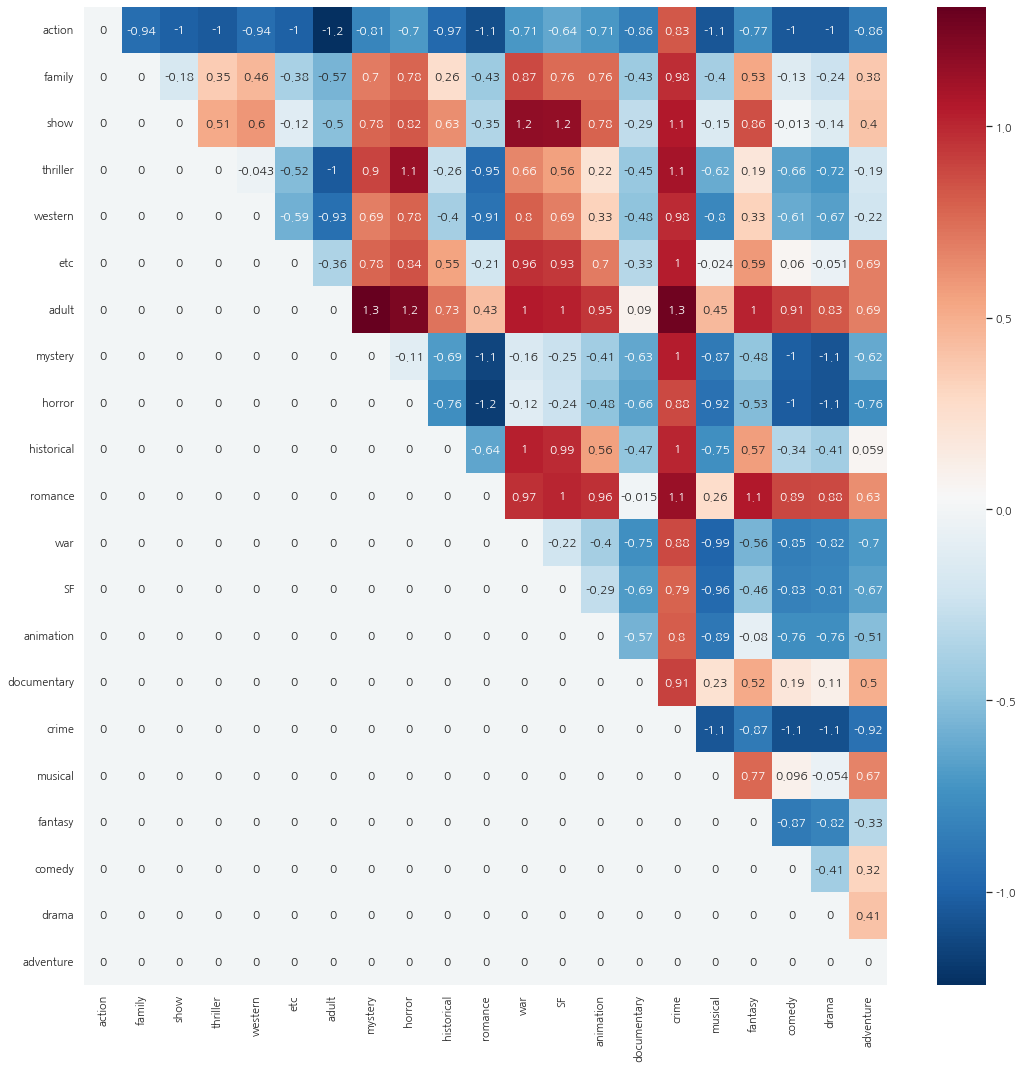

In [95]:
np.random.seed(0)
plt.figure(figsize = (18, 18))
sns.set(font = "NanumGothic")
plt.rcParams['axes.unicode_minus'] = False
ax = sns.heatmap(matrix, xticklabels = genre_name, yticklabels = genre_name, annot = True, cmap = "RdBu_r")
plt.show()

## 5. 회고

**결과 해석**
- art-gen 과의 편향성 관계
- 로맨스, 성인 영화와 같이 사랑을 다루는 영화는 예술에 가깝다고 나온듯 함
- 액션, 전쟁, SF, 범죄, 스릴러, 미스테리의 값은 대부분 음수로 대중 영화와 가깝다고 나옴
- 가족, 연극, 웨스턴, 역사와 같은 장르는 비교하는 대상에 따라 음수/양수 값이 다양하게 나타남

**추가로 실험하면 좋을 것**
- tf-idf로 구한 weat값과 LDA 결과값 비교
- 장르를 대표할 수 있는 단어 찾는 방법 추가적으로 탐색이 필요함